In [45]:
import numpy as np
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from evolvepro.src.data import load_dms_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process.kernels import RBF, ConstantKernel, WhiteKernel, Matern
from sklearn.metrics import mean_absolute_error, r2_score
from scipy.stats import norm
import matplotlib.pyplot as plt

In [28]:
# load dataset
pca_df = pd.read_csv('./output/pca_fit.csv')
labels_df = pd.read_csv('./output/labels_sorted.csv')
labels = pd.DataFrame(labels_df['activity'])
pca_df = pca_df.iloc[:, 3:5]

In [15]:
def expected_improvement(X, X_sample, Y_sample, gp, xi=0.01):
    """
    Computes the Expected Improvement (EI) for candidate points X.
    
    Parameters:
      X         : np.array, candidate points (n_candidates x 2).
      X_sample  : np.array, points already sampled (n_samples x 2).
      Y_sample  : np.array, observed values at X_sample (n_samples,).
      gp        : a trained GaussianProcessRegressor.
      xi        : float, exploration-exploitation trade-off parameter.
    
    Returns:
      EI        : np.array, expected improvement values for each candidate.
    """
    mu, sigma = gp.predict(X, return_std=True)
    sigma = sigma.reshape(-1, 1)
    
    # Since we want to maximize the activity, we use the best observed value so far.
    Y_sample = Y_sample.reshape(-1, 1)
    mu_sample_opt = np.max(Y_sample)
    
    # Compute improvement over the current best.
    improvement = mu.reshape(-1, 1) - mu_sample_opt - xi
    with np.errstate(divide='warn'):
        Z = improvement / sigma
        ei = improvement * norm.cdf(Z) + sigma * norm.pdf(Z)
        ei[sigma == 0.0] = 0.0

    return ei.flatten()

In [66]:
# Choose an initial subset (for example, 10 random points) from the available datapoints.
n_initial = 10
all_indices = np.arange(pca_df.shape[0])
initial_indices = np.random.choice(all_indices, size=n_initial, replace=False)

# These are our initial "queried" points:
X_sample = pca_df.iloc[initial_indices].to_numpy()
Y_sample = labels.iloc[initial_indices].to_numpy()

# Keep track of indices that have been used (queried).
sampled_indices = set(initial_indices)
# Create the GP model.
kernel = Matern(nu=2.5)
gp = GaussianProcessRegressor(kernel=kernel, alpha=1e-6, normalize_y=True)

In [67]:
# Parameters for the BO loop.
n_iter = 10      # total iterations
batch_size = 100  # number of points to add per iteration

# Storage for history.
history_pred = []    # Each element is a tuple (predicted_mean, predicted_std) over all sampled points.
history_actual = []  # Actual observed Y values up to that iteration.
history_indices = [] # Indices of the points queried at each iteration.

for iteration in range(n_iter):
    print(f"Iteration {iteration + 1}/{n_iter}")

    # Fit the GP model to the currently sampled data.
    gp.fit(X_sample, Y_sample)
    
    # Find candidate indices: those that have not been sampled yet.
    candidate_indices = list(set(all_indices) - sampled_indices)
    
    # If there are fewer candidate points than the batch size, break out of the loop.
    if len(candidate_indices) < batch_size:
        print("Not enough candidates left for a full batch. Stopping BO loop.")
        break

    # Evaluate the EI acquisition function on all remaining candidate points.
    X_candidates = pca_df.iloc[candidate_indices].to_numpy()
    EI = expected_improvement(X_candidates, X_sample, Y_sample, gp, xi=0.0001)
    
    # Select the batch_size candidate indices with the highest EI.
    top_indices_relative = np.argsort(EI)[-batch_size:]
    new_indices = [candidate_indices[i] for i in top_indices_relative]
    
    # Retrieve the new points and their true labels.
    X_next = pca_df.iloc[new_indices].to_numpy()
    Y_next = labels.iloc[new_indices].to_numpy()
    
    # Update the sampled data.
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.append(Y_sample, Y_next)
    sampled_indices.update(new_indices)
    
    # Save current predictions on all sampled points.
    mu, sigma = gp.predict(X_sample, return_std=True)
    history_pred.append((mu.copy(), sigma.copy()))
    history_actual.append(Y_sample.copy())
    history_indices.append(list(sampled_indices))
    
    # Optionally, print the best observed activity so far.
    best_val = np.max(Y_sample)
    print(f"  Best observed activity so far: {best_val:.4f}\n")

Iteration 1/10
  Best observed activity so far: 3.7753

Iteration 2/10


/Users/andrewxu/Documents/2025/MD4/MLDE/MLDE_evolvepro/.env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/andrewxu/Documents/2025/MD4/MLDE/MLDE_evolvepro/.env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  Best observed activity so far: 3.8469

Iteration 3/10


/Users/andrewxu/Documents/2025/MD4/MLDE/MLDE_evolvepro/.env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  Best observed activity so far: 3.8469

Iteration 4/10


/Users/andrewxu/Documents/2025/MD4/MLDE/MLDE_evolvepro/.env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  Best observed activity so far: 4.3388

Iteration 5/10


/Users/andrewxu/Documents/2025/MD4/MLDE/MLDE_evolvepro/.env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  Best observed activity so far: 5.1673

Iteration 6/10


/Users/andrewxu/Documents/2025/MD4/MLDE/MLDE_evolvepro/.env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  Best observed activity so far: 5.1673

Iteration 7/10


/Users/andrewxu/Documents/2025/MD4/MLDE/MLDE_evolvepro/.env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  Best observed activity so far: 5.1673

Iteration 8/10


/Users/andrewxu/Documents/2025/MD4/MLDE/MLDE_evolvepro/.env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  Best observed activity so far: 5.1673

Iteration 9/10


/Users/andrewxu/Documents/2025/MD4/MLDE/MLDE_evolvepro/.env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  Best observed activity so far: 6.2461

Iteration 10/10


/Users/andrewxu/Documents/2025/MD4/MLDE/MLDE_evolvepro/.env/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:442: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


  Best observed activity so far: 6.2461




Total number of points queried: 1010


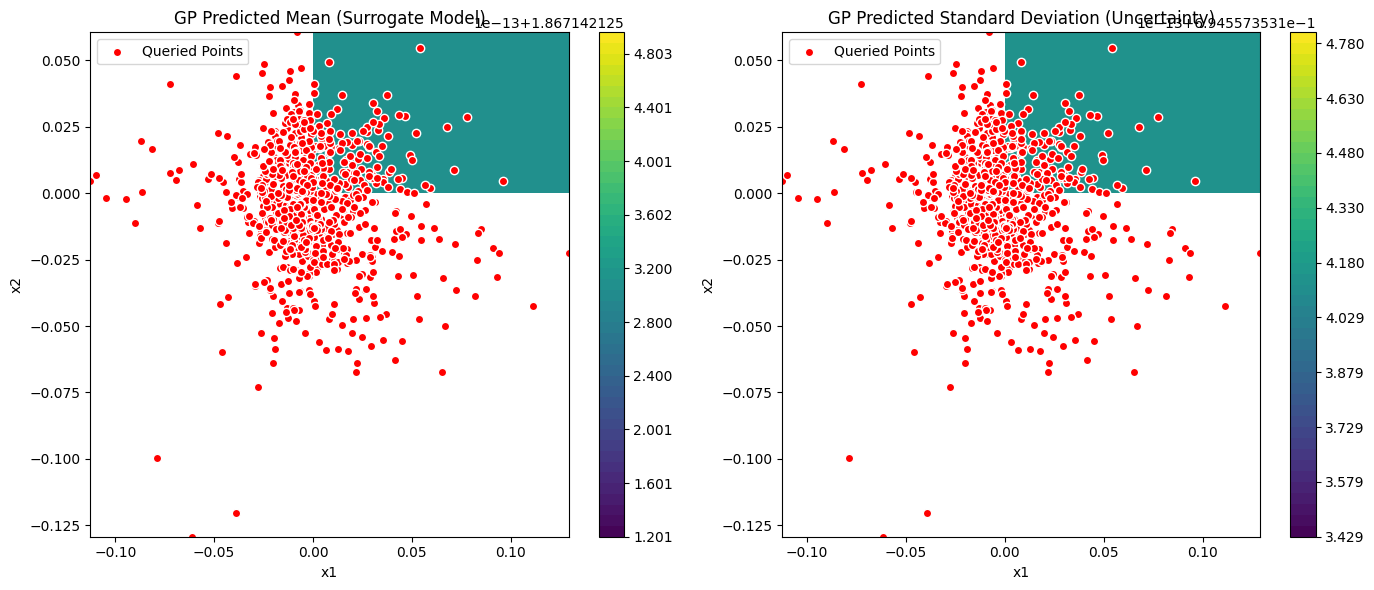


Summary of the Last Iteration:
Total queried points: [6164, 6185, 4487, 4148, 4490, 6211, 4170, 2869, 2160, 6943, 120, 6280, 6290, 156, 6318, 174, 3020, 6368, 4325, 2295, 2297, 4346, 2299, 2300, 2301, 2302, 2303, 2304, 4353, 2306, 6403, 2308, 2309, 2310, 2311, 2312, 2313, 2314, 2315, 2316, 2317, 2318, 2319, 2320, 2321, 2322, 2323, 2324, 2325, 2326, 2327, 2328, 2329, 2330, 2331, 2332, 2333, 2334, 2335, 6977, 2337, 2338, 2339, 2340, 2341, 2342, 295, 2344, 2345, 4394, 2347, 2348, 2349, 2350, 2351, 6448, 2353, 2352, 2346, 2355, 2356, 2354, 2358, 2360, 2361, 314, 2363, 2364, 2365, 2366, 2367, 2368, 2369, 2362, 2371, 2372, 2373, 2374, 2375, 2376, 2377, 2378, 2379, 2380, 2381, 2382, 2383, 2384, 2385, 2386, 6483, 2388, 2389, 2390, 2391, 2392, 2393, 2394, 2395, 2396, 2397, 2398, 2399, 2400, 2401, 2402, 2403, 2404, 2405, 2406, 2407, 2408, 2409, 2410, 2411, 2412, 2413, 2414, 2415, 2416, 2417, 2418, 2419, 2420, 2421, 2422, 2423, 2424, 6521, 2426, 2427, 2428, 2425, 2430, 2431, 2432, 2433, 2434, 24

In [68]:
#print("Final queried points (X_sample):")
#print(X_sample)
#print("\nFinal observed activity values (Y_sample):")
#print(Y_sample)
print("\nTotal number of points queried:", X_sample.shape[0])

# Create a grid for visualization within the limits of the sampled data
x1_min, x1_max = X_sample[:, 0].min(), X_sample[:, 0].max()
x2_min, x2_max = X_sample[:, 1].min(), X_sample[:, 1].max()
# Create a grid for visualization.
n_grid = 100
x1 = np.linspace(0, 5, n_grid)
x2 = np.linspace(0, 5, n_grid)
X1, X2 = np.meshgrid(x1, x2)
grid = np.c_[X1.ravel(), X2.ravel()]

# Use the final GP model to predict on the grid.
mu_grid, sigma_grid = gp.predict(grid, return_std=True)
mu_grid = mu_grid.reshape(X1.shape)
sigma_grid = sigma_grid.reshape(X1.shape)

# Plot the GP predicted mean.
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
contour1 = plt.contourf(X1, X2, mu_grid, levels=50, cmap='viridis')
plt.scatter(X_sample[:, 0], X_sample[:, 1], c='red', edgecolors='w', label='Queried Points')
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.title("GP Predicted Mean (Surrogate Model)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar(contour1)
plt.legend()

# Plot the GP predicted standard deviation (uncertainty).
plt.subplot(1, 2, 2)
contour2 = plt.contourf(X1, X2, sigma_grid, levels=50, cmap='viridis')
plt.scatter(X_sample[:, 0], X_sample[:, 1], c='red', edgecolors='w', label='Queried Points')
plt.xlim(x1_min, x1_max)
plt.ylim(x2_min, x2_max)
plt.title("GP Predicted Standard Deviation (Uncertainty)")
plt.xlabel("x1")
plt.ylabel("x2")
plt.colorbar(contour2)
plt.legend()

plt.tight_layout()
plt.show()

# Optionally, print a summary from the last iteration.
print("\nSummary of the Last Iteration:")
print("Total queried points:", history_indices[-1])
print("Predicted means (first 10 queried points):", history_pred[-1][0][:10])
print("Actual activity values (first 10 queried points):", history_actual[-1][:10])
